## 1) Install and import needed libraries

In [6]:
!pip install deepxde==1.12.1 matplotlib tensorflow scipy pandas

import os
os.environ["DDE_BACKEND"] = "tensorflow" # this MUST be before tensorflow import (enable eager running => can access tf.Variable)!!

import tensorflow as tf
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from deepxde.callbacks import Callback



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


UnboundLocalError: local variable 'child' referenced before assignment

## 2) Define Constants

In [4]:

use_lbfgs = False # train using L-BFGS optimizer or not

BATCH_SIZE = 32  # Batch size

ITERATIONS_ADAM = 50000  # Number of training iterations for Adam
ITERATIONS_LBFGS = 20000  # Number of training iterations for LBFGS
LOSS_WEIGHTS = [1, 1, 1, 1, 1, 1, 1000]  

T_Start = 0
TIME_STEP = 0.10
T_End = 0.10

# Domain size
Start_Width = Start_Length = -1 
WIDTH = LENGTH = 1  

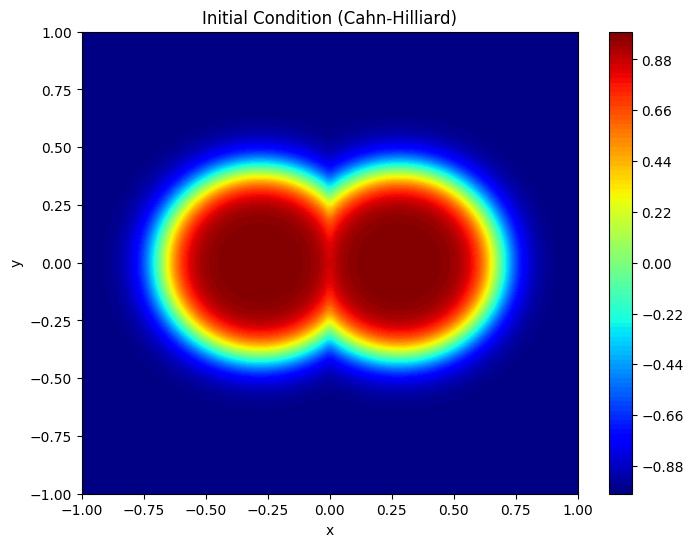

[5.0]
Compiling model...
'compile' took 0.003265 s

Training model...



/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
I0000 00:00:1744065685.493554      34 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                Test loss                                                                 Test metric
0         [3.81e-02, 1.70e+01, 5.11e-02, 3.71e-01, 5.76e-03, 1.21e-03, 1.40e+03]    [2.91e-02, 1.54e+01, 5.11e-02, 3.71e-01, 5.76e-03, 1.21e-03, 1.40e+03]    []  


W0000 00:00:1744065692.237743      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1000      [1.51e+00, 4.20e+00, 3.24e+00, 1.23e+01, 3.55e-01, 7.09e-01, 2.85e+02]    [1.67e+00, 2.86e+00, 3.24e+00, 1.23e+01, 3.55e-01, 7.09e-01, 2.85e+02]    []  

Best model at step 1000:
  train loss: 3.07e+02
  test loss: 3.06e+02
  test metric: []

'train' took 101.334678 s

Iteration: 0, Epsilon Value: 4.4195756912231445
Compiling model...
'compile' took 0.007773 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
1000      [1.51e+00, 4.20e+00, 3.24e+00, 1.23e+01, 3.55e-01, 7.09e-01, 2.85e+02]    [1.67e+00, 2.86e+00, 3.24e+00, 1.23e+01, 3.55e-01, 7.09e-01, 2.85e+02]    []  


W0000 00:00:1744065787.751565      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


KeyboardInterrupt: 

In [5]:

geom = dde.geometry.Rectangle([Start_Width, Start_Length], [WIDTH, LENGTH])  # Geometry domain

time_domain = dde.geometry.TimeDomain(T_Start, T_End)
geomtime = dde.geometry.GeometryXTime(geom, time_domain)

# Generate a grid of points (X, Y) for visualization
x_vals = np.linspace(Start_Width, WIDTH, 100)
y_vals = np.linspace(Start_Length, LENGTH, 100)
X, Y = np.meshgrid(x_vals, y_vals)
XY_grid = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])  # Flatten the grid for function input

# Cahn Hilliard PDE

epsilon = tf.Variable(5.0, dtype=tf.float32, trainable=True)
def cahn_hilliard_Wight(x, y):
    
    u, mu = y[:, 0:1], y[:, 1:2]
    
    du_t = dde.grad.jacobian(y, x, i=0, j=2) # h_t
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    dmu_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dmu_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    f_h = u**3 - u
    
    eq1 = du_t - (dmu_xx + dmu_yy)
    eq2 = mu - (f_h - epsilon**2 * (du_xx + du_yy))
    
    return [eq1, eq2]

# Define the initial condition function using NumPy (for visualization)
r = 0.4
def initial_condition_CA_wight_np(X):
    x_coord = X[:, 0:1]
    y_coord = X[:, 1:2]
    R1 = np.sqrt((x_coord - 0.7 * r) ** 2 + y_coord ** 2)
    R2 = np.sqrt((x_coord + 0.7 * r) ** 2 + y_coord ** 2)
    phi_R1 = np.tanh((r - R1) / (2 * 0.05))
    phi_R2 = np.tanh((r - R2) / (2 * 0.05))
    return np.maximum(phi_R1, phi_R2)


def on_boundary_x(X, on_boundary):
        x, _, _ = X
        return on_boundary and np.isclose(x, Start_Width) or np.isclose(x, WIDTH) 
def on_boundary_y(X, on_boundary):
        _, y, _ = X
        return on_boundary and np.isclose(y, Start_Length) or np.isclose(y, LENGTH)

class SimpleLossTrackingCallback(Callback):
    def __init__(self, every_n_epochs=1000, file_path="/kaggle/working/losses_simple.txt"):
        super(SimpleLossTrackingCallback, self).__init__()
        self.every_n_epochs = every_n_epochs
        self.file_path = file_path
        
        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.file_path), exist_ok=True)
        
        # Check if file exists and is not empty, if so, skip writing the header
        if not os.path.exists(self.file_path) or os.stat(self.file_path).st_size == 0:
            with open(self.file_path, "w") as f:
                f.write("Epoch,PDE Loss,bc_h_x Loss,bc_h_y Loss,bc_h_deriv_x Loss,bc_h_deriv_y Loss,IC Loss,Observe Loss\n")

    def on_epoch_end(self):
        if self.model.train_state.step % self.every_n_epochs == 0 or self.model.train_state.step == 1:
            current_losses = self.model.train_state.loss_train
            loss_str = ",".join(map(str, current_losses))
            with open(self.file_path, "a") as f:
                f.write(f"{self.model.train_state.step},{loss_str}\n")

# to help getting value from tf.Variable
def get_tensor_value(epsilon):
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        value = sess.run(epsilon)
        return value

Z = initial_condition_CA_wight_np(XY_grid).reshape(100, 100)

# Plot the initial condition
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=100, cmap='jet')
plt.colorbar(contour)
plt.title("Initial Condition (Cahn-Hilliard)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


bc_h_x = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=0, component_x=0, on_boundary=on_boundary_x)
bc_h_y = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=0, component_x=1, on_boundary=on_boundary_y)

# Periodic Boundary Conditions for the derivative of 'h' in x and y directions
bc_h_deriv_x = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=1, component_x=0, on_boundary=on_boundary_x)
bc_h_deriv_y = dde.icbc.PeriodicBC(geomtime, component=0, derivative_order=1, component_x=1, on_boundary=on_boundary_y)


# Load the data from the text file - should be in Kaggle as a dataset
initial_data = np.loadtxt("/kaggle/input/0-01epsilon0-1time/time_0.1_epsilon_0.01_ca.txt", delimiter=',')

xy_observ = initial_data[:, 0:2]  # x, y coordinates
eta1_observ = initial_data[:, 2:3]

time_value = 0.10  # Change this to your desired time
xyt_observ = np.hstack((xy_observ, np.full((xy_observ.shape[0], 1), time_value)))

# Define the initial condition using PointSetBC
from deepxde.icbc import PointSetBC
observ_ic_eta1 = PointSetBC(xyt_observ, eta1_observ, component=0)

data_AC = dde.data.TimePDE(
        geomtime, cahn_hilliard_Wight, [bc_h_x, bc_h_y, bc_h_deriv_x, bc_h_deriv_y,  observ_ic_eta1],
        anchors=xyt_observ,
        num_domain=30000, num_boundary=1600, num_test=50000
    )
    
iterations_list = [0]  # Starting with iteration 0
epsilon_values = [epsilon.value().numpy()]
print(epsilon_values)

# Network Architecure
network_size = [3] + [128] * 6 + [2]
net = dde.nn.FNN(network_size, "tanh", "Glorot normal")
variable = dde.callbacks.VariableValue(epsilon, period=1000)
model = dde.Model(data_AC, net)


total_iterations = 0
while total_iterations < ITERATIONS_ADAM:
                # Calculate the number of iterations for this loop
                iterations = 1000
                iter_lr = 1e-3
    
                if total_iterations >= 50000:
                    iter_lr = 1e-4
                                 
                model.compile("adam", lr=iter_lr, loss= 'MSE', loss_weights=LOSS_WEIGHTS, external_trainable_variables=[epsilon])
                      
                losshistory, train_state = model.train(epochs=iterations, display_every=1000)

                if use_lbfgs:
                    model.compile("L-BFGS", loss = 'MSE', loss_weights = LOSS_WEIGHTS, external_trainable_variables=[epsilon])
                    losshistory, train_state = model.train(epochs=ITERATIONS_LBFGS, display_every=1000, callbacks=[detailed_loss_tracker, variable])

                current_epsilon_value = epsilon.value().numpy()
                print(f"Iteration: {total_iterations}, Epsilon Value: {current_epsilon_value}")

                # Record of past epsilons for visualization
                epsilon_values.append(current_epsilon_value)
                iterations_list.append(total_iterations + iterations)

                total_iterations += iterations


## Visulaization

In [ ]:

plt.figure(figsize=(10, 6))
plt.yscale('log')  # Use logarithmic scale if desired

plt.plot(iterations_list, epsilon_values, '-o', label='Iteration vs Epsilon Values', color='blue')

y_ticks = [10**i for i in range(-2, 2)]
plt.yticks(y_ticks, [f"$10^{{{i}}}$" for i in range(-2, 2)], fontsize=12)

plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Epsilon Value', fontsize=14)
plt.title('Iterations vs. Epsilon Value', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Load the losses from the file
file_path = "/kaggle/working/losses_simple.txt"
losses_df = pd.read_csv(file_path)

# Calculate the total loss as the sum of component-wise losses for each iteration
# Assuming that the first column is 'Epoch' and the rest are loss components
loss_components = losses_df.columns[1:]  # Exclude 'Epoch'
losses_df['Total Loss'] = losses_df[loss_components].sum(axis=1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot component-wise losses
for component in loss_components:
    plt.plot(losses_df['Epoch'], losses_df[component], label=component)

# Plot total loss

plt.plot(losses_df['Epoch'], losses_df['Total Loss'], label='Total Loss', color='black', linewidth=2, linestyle='--')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Components and Total Loss over Iterations', fontsize=16)
plt.legend()
plt.grid(True)

plt.show()